In [1]:
from astropy import units as u
from astropy.io import fits
from fil_finder import fil_finder_2D
import matplotlib.pylab as pylab
from shapely import geometry
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
import matplotlib.pyplot as p
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as geometry
from shapely.geometry import MultiPoint
from descartes import PolygonPatch
import os
import numpy as np
from scipy import ndimage as ndi
from skimage.morphology import medial_axis
from shapely.geometry import LineString
from scipy import stats
from skimage.filters.rank import median
from skimage.morphology import disk
import glob
import aplpy
import matplotlib.lines as mlines
import pickle

#the mean molecular weight and the length of a 500 micron pixel in degrees
constants={'mu':2.8, 'pixres': 0.003194, 'hmass': 1.67e-24, 'pad_size':100}

pylab.rcParams['figure.figsize'] = (20.0, 16.0)

basepath="/Users/catherinezucker/Dropbox/Filaments_Comp_Paper/"

def get_path(fil,type):
    if type=="GMF":
        return basepath+type+"/"+fil+"/HIGAL/"
    else:
        return basepath+type+"/"+fil+"/"
        
#taken from Eric Koch's filfinder package 
def padwithzeros(vector, pad_width, iaxis, kwargs):
    vector[:pad_width[0]] = 0
    if pad_width[1] > 0:
        vector[-pad_width[1]:] = 0
    return vector

In [2]:
lengths=[]

fil="Musca"
imgpath='/Users/catherinezucker/Dropbox/Filaments_Comp_Paper/Musca/HGBS_musca_column_density_map.fits'
maskpath='/Users/catherinezucker/Dropbox/Filaments_Comp_Paper/Musca/Musca_filfind_mask.fits'

dist=200

img,hdr=fits.getdata(imgpath,header=True)
        
filmask=fits.getdata(maskpath)
fils=fil_finder_2D(img,hdr,beamwidth=36.3*u.arcsec, distance=dist*u.pc,mask=filmask)

#create the mask
fils.create_mask(verbose=False,use_existing_mask=True)

#do the skeletonization
fils.medskel(verbose=False)

#find longest path through skeleton
analysis=fils.analyze_skeletons(verbose=False)
 
length=np.sum(fils.lengths)

//anaconda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
//anaconda/envs/py27/lib/python2.7/site-packages/fil_finder/filfind_class.py:386: UserWarning: Using inputted mask. Skipping creation of a new mask.
  warnings.warn("Using inputted mask. Skipping creation of a new mask.")


In [3]:
fits.writeto("Musca_longpath.fits",fils.skeleton_longpath,hdr,clobber=True)

In [4]:
print(length)

8.19425537027


In [5]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from scipy.interpolate import splprep
from scipy.interpolate import splev


def curveorder(pts):

    clf = NearestNeighbors(2).fit(pts)
    G = clf.kneighbors_graph()


    T = nx.from_scipy_sparse_matrix(G)

    order = list(nx.dfs_preorder_nodes(T, 0))

    xx = x[order]
    yy = y[order]

    paths = [list(nx.dfs_preorder_nodes(T, i)) for i in range(len(pts))]

    mindist = np.inf
    minidx = 0

    for i in range(len(pts)):
        p = paths[i]           # order of nodes
        ordered = pts[p]    # ordered nodes
        # find cost of that order by the sum of euclidean distances between points (i) and (i+1)
        cost = (((ordered[:-1] - ordered[1:])**2).sum(1)).sum()
        if cost < mindist:
            mindist = cost
            minidx = i
        
    opt_order = paths[minidx]

    xx = x[opt_order]
    yy = y[opt_order]
    
    return(xx,yy)

pixcrd=np.where(fils.skeleton_longpath==1)
x=pixcrd[1]
y=pixcrd[0]
pts=np.vstack((x,y)).T
xx,yy=curveorder(pts)

In [6]:
def maskbounds(points,xfit,ax,plot_width=True):
    
    dist=[]
    distpc=[]
    finalpts=[]
    leftx=[]
    rightx=[]
    lefty=[]
    righty=[]
            
    for i in range(0,len(points)):

        a=points[i]
        argmin=np.argmin(np.abs(xfit-np.ones((xfit.shape[0]))*a))
        fa=yfit[argmin]   
        fprime=yprime[argmin]/xprime[argmin]
        m=-1.0/fprime
        deltay=.1
                
        deltax=(deltay/np.absolute(m))
        linerange=np.arange(1,10000,1)
                    
        for line in linerange:
            findxbound=np.linspace(a-line*deltax,a+line*deltax,100)
            findybound=np.array(fa+(-1.0/fprime)*(findxbound-a)) # tangent
            
            if (np.min(findxbound)<0) or (np.max(findxbound)>img.shape[1]-1) or (np.min(findybound)<0) or (np.max(findybound)>img.shape[0]-1):
                print(a,'Bad point...skipping')
                break
            
            boundarr=filmask[findybound.astype(int),findxbound.astype(int)]
            halved=findxbound.shape[0]/2

            if ((np.any(boundarr[:halved])==True and np.count_nonzero(boundarr[halved:])==0)==True or (np.any(boundarr[halved:])==True and np.count_nonzero(boundarr[:halved])==0)==True):
                    
                lhs = np.where(boundarr==1)[0][0]
                rhs = np.where(boundarr==1)[0][-1]
                
                fin_x=findxbound[lhs:rhs+1]
                fin_tanperp=findybound[lhs:rhs+1]
                
                leftx.append(fin_x[0])
                rightx.append(fin_x[-1])
    
                lefty.append(fin_tanperp[0])
                righty.append(fin_tanperp[-1])            
                                                    
                dist = math.hypot(fin_x[0] - fin_x[-1], fin_tanperp[0] - fin_tanperp[-1])
                distpc.append(dist*fils.imgscale)
                
                if plot_width==True:
                    ax.plot(fin_x,fin_tanperp,ls='solid',c='r',alpha=1.0,zorder=2)  
                    
                finalpts.append(a)
                       
                break
                
            if (np.all(boundarr[:halved])==0 and np.all(boundarr[halved:])==0 and np.any(boundarr)==1)==True:

                lhs = np.where(boundarr[:halved]==0)[0][-1]
                rhs = np.where(boundarr[halved:]==0)[0][0]
                
                fin_x=findxbound[lhs:rhs+halved]
                fin_tanperp=findybound[lhs:rhs+halved]
                                    
                leftx.append(fin_x[0])
                rightx.append(fin_x[-1])
    
                lefty.append(fin_tanperp[0])
                righty.append(fin_tanperp[-1])            
                                                    
                dist = math.hypot(fin_x[0] - fin_x[-1], fin_tanperp[0] - fin_tanperp[-1])
                distpc.append(dist*fils.imgscale)
                    
                if plot_width==True:
                    ax.plot(fin_x,fin_tanperp,ls='solid',c='r',alpha=1.0,zorder=2)   
                    
                finalpts.append(a)
                    
                break 

    return (np.array(leftx),np.array(rightx),np.array(lefty),np.array(righty),np.array(distpc),np.array(finalpts))


def max_intensity(points,xfit,leftx,rightx,lefty,righty,ax):
    maxcolx=[]
    maxcoly=[]

    for i in range(0,len(points)):
            
        a=points[i]
        argmin=np.argmin(np.abs(xfit-np.ones((xfit.shape[0]))*a))
        fa=yfit[argmin]   
        fprime=yprime[argmin]/xprime[argmin]
        m=-1.0/fprime
                
        findxbound=np.linspace(np.min([leftx[i],rightx[i]]),np.max([leftx[i],rightx[i]]),100)
        findybound=np.array(fa+(-1.0/fprime)*(findxbound-a)) # tangent
            
        unique,indices,inverse,counts=np.unique(img[findybound.astype(int),findxbound.astype(int)],return_index=True,return_inverse=True,return_counts=True)
    
        uniquex=findxbound.astype(int)[indices]
        uniquey=findybound.astype(int)[indices]
    
        order=np.argsort(indices)
        indices=indices[order]
        counts=counts[order]

        extract=[]
        for j in range(0,len(counts)):
            extract.append(np.sum(counts[0:j])+counts[j]/2)
        
        coldensity=img[findybound.astype(int)[extract],findxbound.astype(int)[extract]]/(1e+22)
    
        argmax=np.argmax(coldensity)
        maxcolx.append(int(findxbound[extract[argmax]]))
        maxcoly.append(int(findybound[extract[argmax]]))
        
    return np.array(maxcolx),np.array(maxcoly)
    
def get_radial_prof(points,xfit,maxcolx,maxcoly,cutdist,ax,plot_max=True,plot_all=True):
    
    xaxis=[]
    yaxis=[]
    
    indexedarr=np.cumsum(np.ones((img.shape))).reshape((img.shape))
    
    for i in range(0,len(points)):
        a=points[i]
        argmin=np.argmin(np.abs(xfit-np.ones((xfit.shape[0]))*a))
        fa=yfit[argmin]   
        fprime=yprime[argmin]/xprime[argmin]
        m=-1.0/fprime
        
        deltaylower=fa-3
        deltayupper=img.shape[0]-fa-3
        deltaxlower=(deltaylower/np.absolute(m))
        deltaxupper=(deltayupper/np.absolute(m))
        
        if np.sign(m)==-1:
            findxbound=np.linspace(np.clip(a-deltaxupper,0,a),np.clip(a+deltaxlower,a,img.shape[1]-3),100000)
        else:
            findxbound=np.linspace(np.clip(a-deltaxlower,0,a),np.clip(a+deltaxupper,a,img.shape[1]-3),100000)
            
        findybound=np.array(fa+(-1.0/fprime)*(findxbound-a)) # tangent

        unique,indices,inverse,counts=np.unique(indexedarr[findybound.astype(int),findxbound.astype(int)],return_index=True,return_inverse=True,return_counts=True)

        uniquex=findxbound.astype(int)[indices]
        uniquey=findybound.astype(int)[indices]

        order=np.argsort(indices)
        indices=indices[order]
        counts=counts[order]

        extract=[]
        for j in range(0,len(counts)):
            extract.append(np.sum(counts[0:j])+counts[j]/2)

        coldensity=img[findybound.astype(int)[extract],findxbound.astype(int)[extract]]/(1e+22)

        radialdist=[]
        center = np.where(((findxbound.astype(int)[extract]==maxcolx[i]) & (findybound.astype(int)[extract]==maxcoly[i]))==True)[0]
        centerx=findxbound[extract][center]
        centery=findybound[extract][center]
        for pt in zip(findxbound[extract],findybound[extract]):
            radialdist.append(math.hypot(pt[0] - centerx, pt[1] - centery))

        radialdist=np.array(radialdist)*fils.imgscale
 
        leftspine=np.where(findxbound[extract]<centerx)
        radialdist[leftspine[0]]=radialdist[leftspine[0]]*-1

        deletepts=np.where(np.abs(radialdist)>cutdist)
        radialdist=np.delete(radialdist,deletepts)
        coldensity=np.delete(coldensity,deletepts)
        extract=np.delete(extract,deletepts)

        xaxis.append(radialdist)
        yaxis.append(coldensity)

        if indexedarr[findybound.astype(int)[extract],findxbound.astype(int)[extract]].shape[0]!=np.unique(indexedarr[findybound.astype(int)[extract],findxbound.astype(int)[extract]]).shape[0]:
            print(a,"Something is wrong!!! Profile has repeat column density values")

        if plot_all==True:
            ax.scatter(findxbound[extract],findybound[extract],c='green',edgecolor="None",zorder=4,s=20)
        if plot_max==True:
            ax.scatter(centerx,centery,c='blue',edgecolor="None",zorder=4,s=20,marker='x')

                
    return np.array(xaxis),np.array(yaxis)


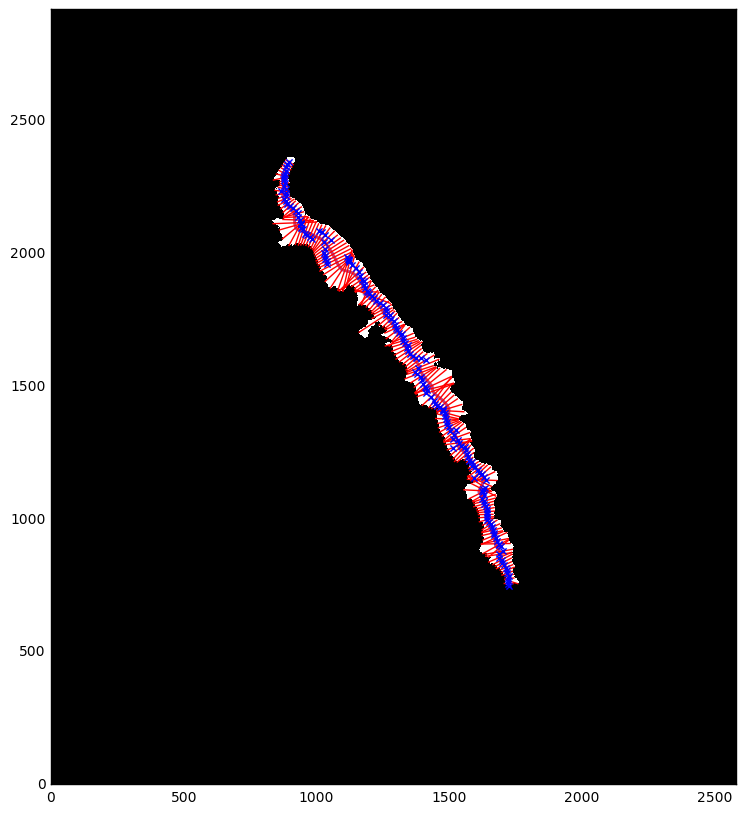

In [7]:
# make ascending spiral in 3-space
%matplotlib inline
from matplotlib.colors import LogNorm

t=np.arange(0,xx.shape[0],1)

x = xx
y = yy
z = t

# spline parameters
s=50 # smoothness parameter
k=5 # spline order
nest=-1 # estimate of number of knots needed (-1 = maximal)

# find the knot points
tckp,u = splprep([x,y,z],k=k,nest=-1)

# evaluate spline, including interpolated points
xfit,yfit,zfit = splev(u,tckp)
xprime,yprime,zprime = splev(u,tckp,der=1)

import pylab
fig=plt.figure(figsize=(10,10))
ax=plt.gca()
plt.imshow(filmask,origin='lower',zorder=1,cmap='binary_r',interpolation='nearest',extent=[0,filmask.shape[1],0,filmask.shape[0]])#,norm=LogNorm())
plt.ylim(0,img.shape[0])
plt.xlim(0,img.shape[1])
plt.plot(xx,yy,'b',label='data',lw=2,alpha=0.5)
plt.plot(xfit,yfit,'r',label='fit',lw=2,alpha=0.5)
cutdist=2
points=xfit[::10]
leftx,rightx,lefty,righty,distpc,finalpts=maskbounds(points,xfit,ax)
maxcolx,maxcoly=max_intensity(finalpts,xfit,leftx,rightx,lefty,righty,ax)
xaxis,yaxis=get_radial_prof(finalpts,xfit,maxcolx,maxcoly,cutdist,ax,plot_all=False)


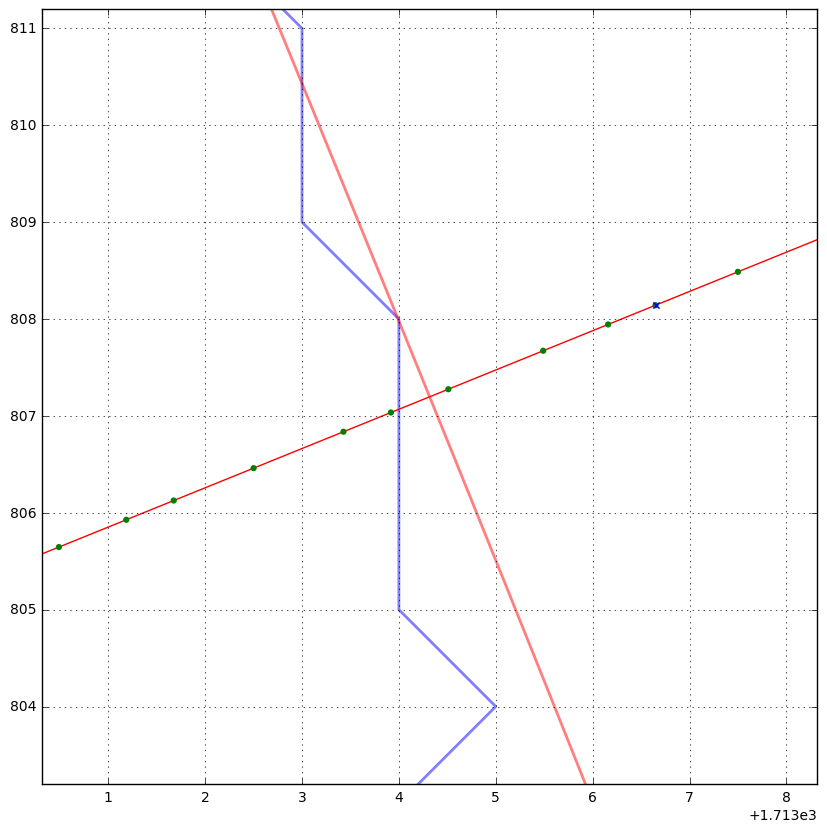

In [8]:
import pylab
fig=plt.figure(figsize=(10,10))
ax=plt.gca()
plt.imshow(filmask,origin='lower',zorder=1,cmap='binary_r',interpolation='nearest',extent=[0,filmask.shape[1],0,filmask.shape[0]])#,norm=LogNorm())
plt.ylim(0,img.shape[0])
plt.xlim(0,img.shape[1])
plt.plot(xx,yy,'b',label='data',lw=2,alpha=0.5)
plt.plot(xfit,yfit,'r',label='fit',lw=2,alpha=0.5)
cutdist=2
points=xfit[::10]
leftx,rightx,lefty,righty,distpc,finalpts=maskbounds(points,xfit,ax)
maxcolx,maxcoly=max_intensity(finalpts,xfit,leftx,rightx,lefty,righty,ax)
xaxis,yaxis=get_radial_prof(finalpts,xfit,maxcolx,maxcoly,cutdist,ax,plot_all=True)

a=1717.31781063
argmin=np.argmin(np.abs(xfit-np.ones((xfit.shape[0]))*a))
fa=yfit[argmin]   
plt.xlim(a-4,a+4)
plt.ylim(fa-4,fa+4)
plt.grid(True)

(0, 1)

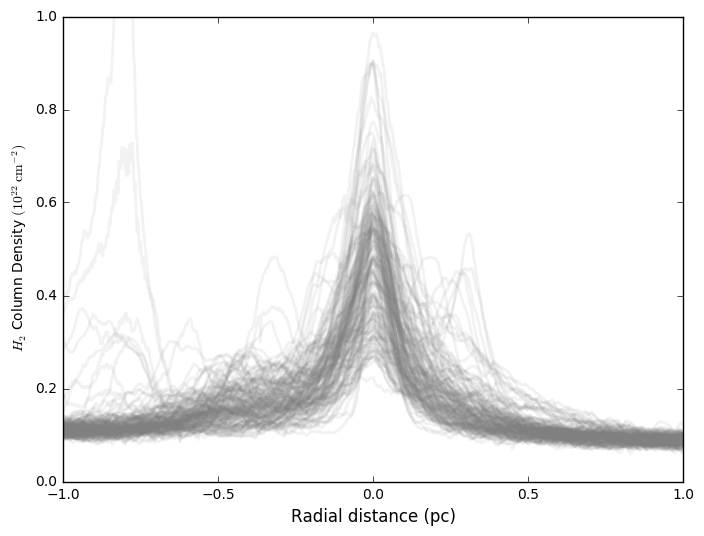

In [9]:
from scipy.interpolate import interp1d

xtot=[]
ytot=[]

fig=plt.figure(figsize=(8,6))

for i in range(0,len(xaxis)):
    sample=np.linspace(np.trunc(np.min(xaxis[i])),np.trunc(np.max(xaxis[i])),1000)
    f = interp1d(xaxis[i], yaxis[i])
    xresamp=sample
    yresamp=f(sample)
    xtot.append(xresamp)
    ytot.append(yresamp)
    plt.plot(xresamp,yresamp,c='gray',alpha=0.1,lw=2)
    
plt.xlabel("Radial distance (pc)",fontsize=12)
plt.ylabel(r" $H_2$ Column Density $\rm (10^{22} \; cm^{-2})$",fontsize=10)
plt.ylim(0,1)

In [10]:
def make_master_prof(xtot,ytot,fitdist):
    xplot=np.hstack(xtot)
    yplot=np.hstack(ytot)
    bins=np.linspace(-fitdist,fitdist,int(fitdist*2/0.01))
    binorder=np.argsort(xplot)
    xplot=xplot[binorder]
    yplot=yplot[binorder]
    inds = np.digitize(xplot, bins)

    masterx=[]
    mastery=[]
    std=[]
    for i in range(0,np.max(inds)):
        masterx.append(np.nanmedian(xplot[np.where(inds==i)]))
        mastery.append(np.nanmedian(yplot[np.where(inds==i)]))
        std.append(np.nanstd(yplot[np.where(inds==i)]))

    masterx=np.array(masterx)
    mastery=np.array(mastery)
    std=np.array(std)
    
    mask=np.isfinite(masterx)
    masterx=masterx[mask][1:]
    mastery=mastery[mask][1:]
    std=std[mask][1:]
    
    return(masterx,mastery,std)

In [11]:
from lmfit.models import Model

fwhm_factor=2 * np.sqrt(2 * np.log(2))

#adapted from Eric Koch's filfinder code
def gaussian(x, amp, wid, bg):
    "1-d gaussian: gaussian(x, amp, wid, bg)"
    return (amp - bg) * np.exp(-1 * np.power(x, 2) / (2 * np.power(wid, 2))) + bg

def lorentzian(x,amp,fwhm,bg):
    return (amp - bg) * (0.5 * fwhm) ** 2 / ((0.5 * fwhm) ** 2 + x ** 2) + bg

def cylindrical(r,i,N_0,R_flat,p):
    i=0
    return (1/np.degrees(np.cos(i))) * N_0 / (1+(r/R_flat)**2)**((p-1)/2.0) 

# Before we see our results, here's the results from Cox+2016:
## Gaussian Fit: FWHM=0.14 pc +/- 0.03 pc
## Cylindrical Fit: R_flat=0.08 pc, p=2.2 +/- 0.3
<img src="Cox2016.png">

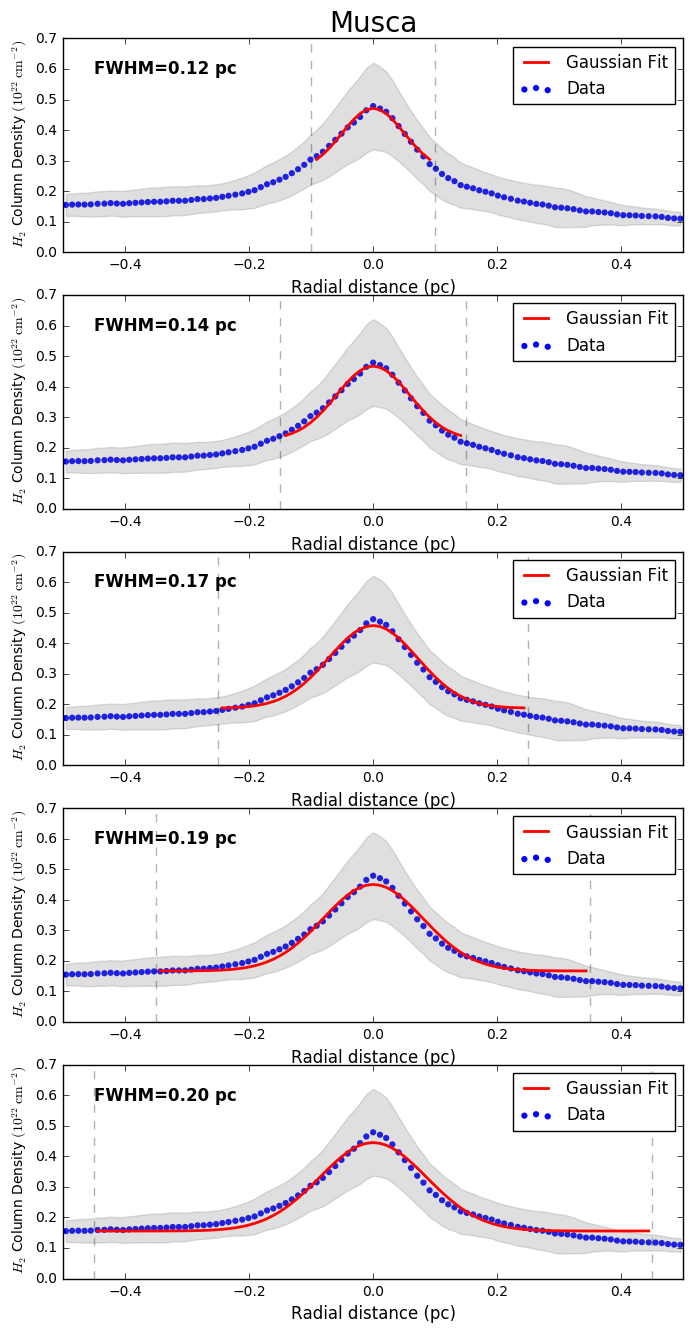

In [12]:
plt.figure(figsize=(6,10))

fitdist=[0.1,0.15,0.25,0.35,0.45]
finalwidth=[]

fig, ax = plt.subplots(nrows=len(fitdist), ncols=1,figsize=(8,16))

for i in range(0,len(fitdist)):
    
    masterx,mastery,std=make_master_prof(xtot,ytot,0.5)
    include=np.where(np.abs(masterx)<fitdist[i])

    gmod = Model(gaussian)
    gresult = gmod.fit(mastery[include], x=masterx[include], amp=np.max(mastery[include]),wid=np.median(distpc)/2.0,bg=np.min(mastery[include]))

    #lmod = Model(lorentzian)
    #lresult = lmod.fit(mastery[include], x=masterx[include], amp=np.max(mastery),fwhm=np.median(distpc)*fwhm_factor)
    
    if i==0:
        ax[i].set_title(fil,fontsize=20)
        
    ax[i].scatter(masterx, mastery, c='b',label="Data",edgecolor='None')
    ax[i].plot(masterx[include], gresult.best_fit, 'r-',label="Gaussian Fit",lw=2)
    ax[i].fill_between(masterx, mastery-std, mastery+std,color='gray',alpha=0.25)
    #plt.plot(masterx, lresult.best_fit, 'g-',label="Lorentzian",lw=2)
    ax[i].set_xlim(-0.5,0.5)
    ax[i].set_xlabel("Radial distance (pc)",fontsize=12)
    ax[i].set_ylabel(r" $H_2$ Column Density $\rm (10^{22} \; cm^{-2})$",fontsize=10)
    ax[i].axvline(-fitdist[i],c='k',ls='dashed',alpha=0.3)
    ax[i].axvline(+fitdist[i],c='k',ls='dashed',alpha=0.3)
    img_beam=fils.beamwidth
    factor = 2 * np.sqrt(2 * np.log(2))  # FWHM factor
    deconv = (factor * np.absolute(gresult.best_values['wid'])) ** 2. - img_beam ** 2.
    finalwidth.append(np.sqrt(deconv))
    
    ax[i].text(0.05, 0.9,'FWHM={:.2f} pc'.format(np.sqrt(deconv)), horizontalalignment='left',
          verticalalignment='top', fontsize=12, fontweight='bold',
          transform=ax[i].transAxes)

    ax[i].legend()


plt.savefig(fil+"_profile_fits.png")


# We can reproduce the Cox et al. 2016 results for Musca if we only fit within +/- 0.15 pc (the top panel)

//anaconda/envs/py27/lib/python2.7/site-packages/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self.coord == x or self.axis.apl_tick_positions_world[ipos] > 0:


INFO: Auto-setting vmin to  5.938e+20 [aplpy.core]
INFO: Auto-setting vmax to  5.958e+21 [aplpy.core]


//anaconda/envs/py27/lib/python2.7/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.
//anaconda/envs/py27/lib/python2.7/site-packages/numpy/ma/core.py:867: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)
//anaconda/envs/py27/lib/python2.7/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


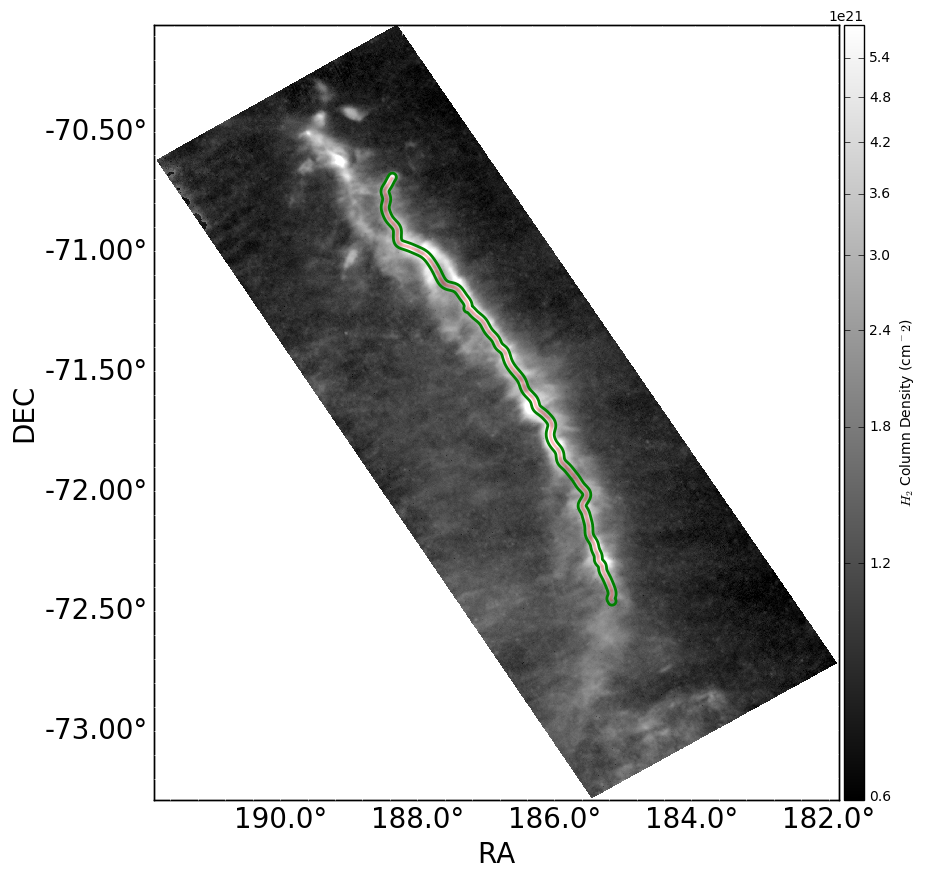

In [13]:
spine=LineString([(i[0]+1, i[1]+1) for i in zip(xfit,yfit)])
        
boundary = spine.buffer(finalwidth[0]/fils.imgscale/2.0)

boundarypatch=PolygonPatch(boundary)
boundaryline=boundarypatch.get_verts() #green boundary of MST filament

#now let's plot everything:
myfig=plt.figure(figsize=(10,10))
fig=aplpy.FITSFigure(imgpath, figure=myfig)
fig.show_grayscale(stretch='log')
fig.tick_labels.set_font(family='sans-serif', size='large')
fig.tick_labels.set_xformat("dd.d")
fig.tick_labels.set_yformat("d.dd")
fig.axis_labels.set_font(family='sans-serif',size='large')
fig.axis_labels.set_xtext("RA")
fig.axis_labels.set_ytext("DEC")
fig.axis_labels.set_font(size=20)
fig.tick_labels.set_font(size=20)
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'$H_2$ Column Density (cm$^-2$)')
x_world, y_world = fig.pixel2world(boundaryline[:,0],boundaryline[:,1])
linelist=np.vstack((x_world,y_world))
fig.show_lines([linelist],color="green",lw=2)
    
x_worldc, y_worldc=fig.pixel2world(xfit+1,yfit+1)
linelistc=np.vstack((x_worldc,y_worldc))
fig.show_lines([linelistc],color="red",lw=2,alpha=0.25)
plt.savefig("Musca_cylinder.png")

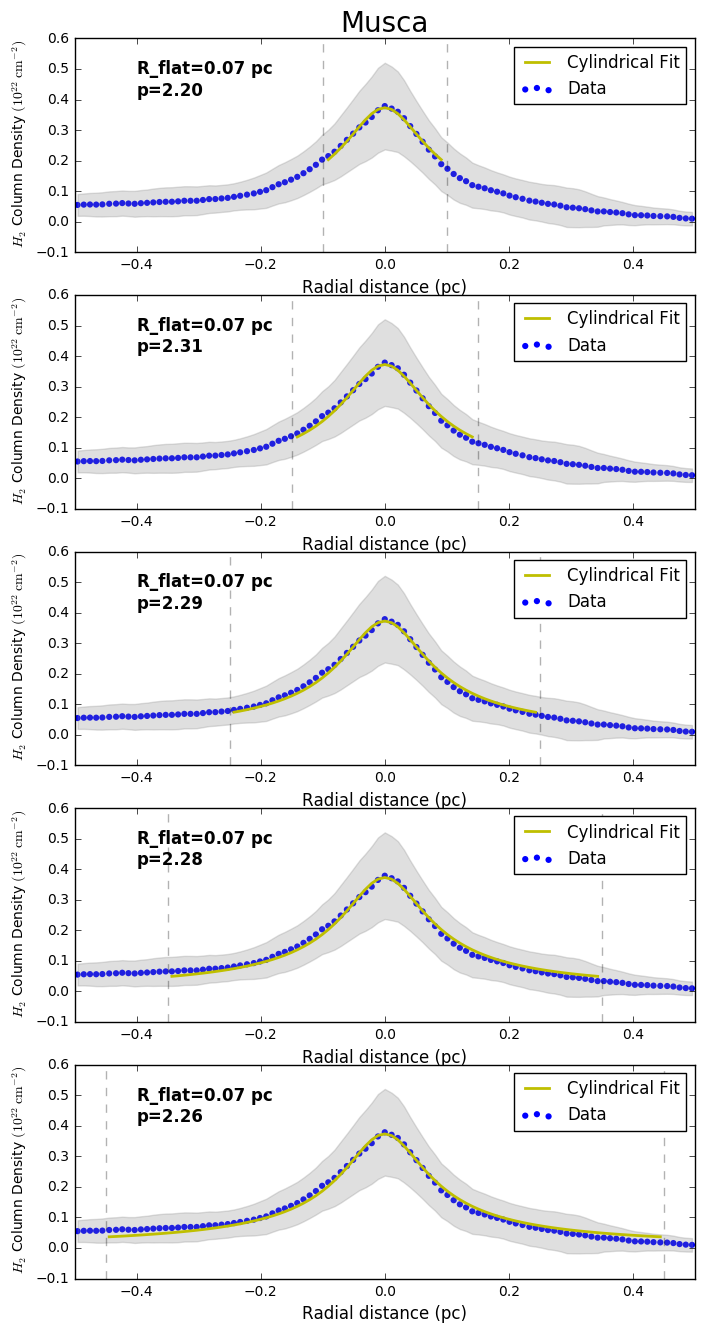

In [14]:
plt.figure(figsize=(6,10))

fitdist=[0.1,0.15,0.25,0.35,0.45]
finalwidth=[]

fig, ax = plt.subplots(nrows=len(fitdist), ncols=1,figsize=(8,16))

for i in range(0,len(fitdist)):
    
    masterx,mastery,std=make_master_prof(xtot,ytot,0.5)
    mastery=mastery-((1e+21)/(1e+22)) ##subtract off Cox+2016 BG value

    include=np.where(np.abs(masterx)<fitdist[i])


    cmod=Model(cylindrical)
    cresult = cmod.fit(mastery[include],r=masterx[include],i=0.0,N_0=.475,R_flat=0.08,p=2.2)

    if i==0:
        ax[i].set_title(fil,fontsize=20)
        
    ax[i].scatter(masterx, mastery, c='b',label="Data",edgecolor='None')
    ax[i].plot(masterx[include], cresult.best_fit, 'y-',label="Cylindrical Fit",lw=2)
    ax[i].fill_between(masterx, mastery-std, mastery+std,color='gray',alpha=0.25)
    ax[i].set_xlim(-0.5,0.5)
    ax[i].set_xlabel("Radial distance (pc)",fontsize=12)
    ax[i].set_ylabel(r" $H_2$ Column Density $\rm (10^{22} \; cm^{-2})$",fontsize=10)
    ax[i].axvline(-fitdist[i],c='k',ls='dashed',alpha=0.3)
    ax[i].axvline(+fitdist[i],c='k',ls='dashed',alpha=0.3)
    img_beam=fils.beamwidth
    factor = 2 * np.sqrt(2 * np.log(2))  # FWHM factor
    deconv = (factor * np.absolute(gresult.best_values['wid'])) ** 2. - img_beam ** 2.
    finalwidth.append(np.sqrt(deconv))
    
    ax[i].text(0.1, 0.9,'R_flat={:.2f} pc'.format(np.absolute(cresult.best_values['R_flat'])), horizontalalignment='left',
          verticalalignment='top', fontsize=12, fontweight='bold',
          transform=ax[i].transAxes)
    ax[i].text(0.1, 0.8,'p={:.2f}'.format(cresult.best_values['p']), horizontalalignment='left',
          verticalalignment='top', fontsize=12, fontweight='bold',
          transform=ax[i].transAxes)

    ax[i].legend()
